In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
from torch.nn import CrossEntropyLoss
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torchinfo import summary

from os.path import exists

from util import test_loss, train_NN, loadCIFAR10, plot_loss, plot_acc, plot_shifts, inference_time, ASL_plot_acc, ASL_plot_loss

plt.rcParams['figure.dpi'] = 100

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [3]:
batch_size = 100
input_shape = (batch_size, 3, 32, 32)
num_labels = 10

train_dataset, train_dataloader, test_dataset, test_dataloader, classes = loadCIFAR10(batch_size)

Files already downloaded and verified
Files already downloaded and verified


## CIFAR10 LeNet

In [4]:
# mock train_function of Optimizer to load the optimizer
train_function = None

with open('models/LeNet_Cifar/LeNet_optimizer.pkl', 'rb') as file:
    LeNet_optim = pickle.load(file)

best_parameters = LeNet_optim.get_best_parameters(3)
print(best_parameters)
parameters = best_parameters[0]

[{'acc': 69.994, 'lr': 0.09375, 'momentum': 0.65625, 'p_randomTransform': 0.3125}, {'acc': 69.69, 'lr': 0.046875, 'momentum': 0.734375, 'p_randomTransform': 0.84375}, {'acc': 69.654, 'lr': 0.12307617187499999, 'momentum': 0.6230761718750002, 'p_randomTransform': 0.5936914062499999}]


In [5]:
from Models import LeNet

LeNN = LeNet(input_shape, num_labels, initial_lr=parameters["lr"], momentum=parameters["momentum"], weight_decay=0)

summary(LeNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 32, 32]          456
│    └─BatchNorm2d: 2-2                  [100, 6, 32, 32]          12
│    └─Tanh: 2-3                         [100, 6, 32, 32]          --
│    └─AvgPool2d: 2-4                    [100, 6, 16, 16]          --
│    └─Conv2d: 2-5                       [100, 16, 16, 16]         2,416
│    └─BatchNorm2d: 2-6                  [100, 16, 16, 16]         32
│    └─Tanh: 2-7                         [100, 16, 16, 16]         --
│    └─AvgPool2d: 2-8                    [100, 16, 8, 8]           --
│    └─Flatten: 2-9                      [100, 1024]               --
│    └─Linear: 2-10                      [100, 120]                123,000
│    └─Tanh: 2-11                        [100, 120]                --
│    └

In [6]:
PATH = "models/LeNet_Cifar/LeNet.pth"

if exists(PATH):
    LeNN = torch.load(PATH)
    LeNN.eval()

In [7]:
criterion = CrossEntropyLoss()
epochs = 20

train_NN(LeNN, criterion, train_dataloader, test_dataloader, epochs=epochs, batches_to_test=100,
        patience=2,device=device, print_test=True, verbose=True, p_randomTransform=parameters["p_randomTransform"])

[1,   100] train_loss: 1.928
test_loss: 1.805, test_accuracy: 35.54
[1,   200] train_loss: 1.745
test_loss: 1.651, test_accuracy: 41.89
[1,   300] train_loss: 1.648
test_loss: 1.617, test_accuracy: 42.73
[1,   400] train_loss: 1.549
test_loss: 1.467, test_accuracy: 47.14
[1,   500] train_loss: 1.517
test_loss: 1.430, test_accuracy: 48.32
[2,   100] train_loss: 1.428
test_loss: 1.393, test_accuracy: 49.71
[2,   200] train_loss: 1.415
test_loss: 1.367, test_accuracy: 50.85
[2,   300] train_loss: 1.385
test_loss: 1.351, test_accuracy: 51.79
[2,   400] train_loss: 1.365
test_loss: 1.354, test_accuracy: 51.53
[2,   500] train_loss: 1.328
test_loss: 1.351, test_accuracy: 51.95
[3,   100] train_loss: 1.270
test_loss: 1.275, test_accuracy: 54.29
[3,   200] train_loss: 1.280
test_loss: 1.265, test_accuracy: 54.57
[3,   300] train_loss: 1.258
test_loss: 1.240, test_accuracy: 55.51
[3,   400] train_loss: 1.253
test_loss: 1.231, test_accuracy: 55.91
[3,   500] train_loss: 1.243
test_loss: 1.214, t

In [8]:
torch.save(LeNN, "./models/LeNet_Cifar/LeNet.pth")

In [5]:
LeNN = torch.load("./models/LeNet_Cifar/LeNet.pth")

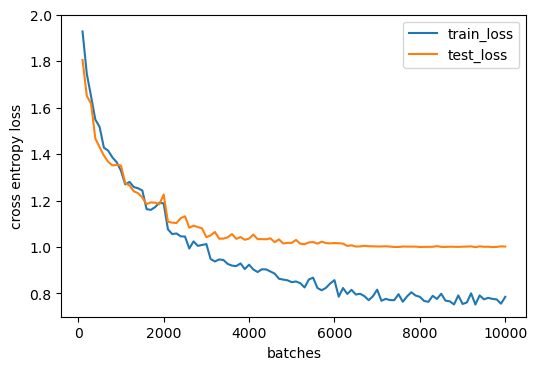

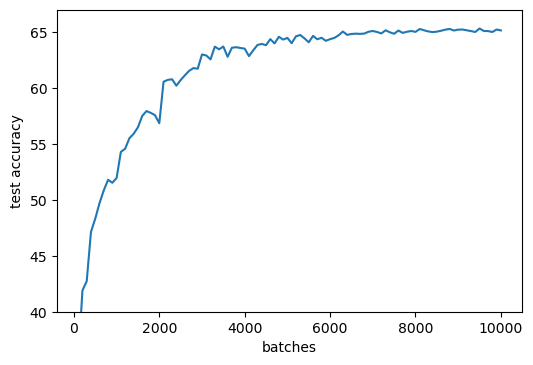

In [44]:
plot_loss(LeNN, y_lim=(0.7,2))
plot_acc(LeNN, y_lim=(40, 67))

In [5]:
print("Training time (s):")
print(f"mean: {round(np.mean(LeNN.train_time), 3)}")
print(f"std: {round(np.std(LeNN.train_time), 3)}")

Training time (s):
mean: 1.007
std: 0.172


In [25]:
inference_times = inference_time(LeNN, input_shape=(1, 3, 32, 32), repetitions=10000, device="cuda")
print("Inference time GPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time GPU (ms):
3.294e-01
4.3e-02


In [26]:
inference_times = inference_time(LeNN, input_shape=(1, 3, 32, 32), repetitions=10000, device="cpu")
print("Inference time CPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time CPU (ms):
3.452e-01
1.0e-01


In [27]:
inference_times = inference_time(LeNN, input_shape=(100, 3, 32, 32), repetitions=10000, device="cuda")
print("Inference time GPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time GPU (ms):
2.009e+00
3.9e-02


In [28]:
inference_times = inference_time(LeNN, input_shape=(100, 3, 32, 32), repetitions=10000, device="cpu")
print("Inference time CPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time CPU (ms):
3.055e+00
8.8e-01


## CIFAR10 LeASLNet

In [17]:
# mock train_function of Optimizer to load the optimizer
ASL_train_function = None

with open('models/LeNet_Cifar/LeASLNet_optimizer.pkl', 'rb') as file:
    LeASLNet_optim = pickle.load(file)

best_parameters = LeASLNet_optim.get_best_parameters(3)
print(best_parameters)
parameters = best_parameters[2]

[{'acc': 70.484, 'lr': 0.026123046875, 'momentum': 0.928466796875, 'p_randomTransform': 0.00634765625}, {'acc': 69.916, 'lr': 0.09375, 'momentum': 0.65625, 'p_randomTransform': 0.3125}, {'acc': 67.734, 'lr': 0.08906396834655647, 'momentum': 0.5747879624008334, 'p_randomTransform': 0.6465142614354319}]


In [18]:
from Models import LeASLNet

LeASLNN = LeASLNet(input_shape, num_labels, initial_lr=parameters["lr"], momentum=parameters["momentum"], weight_decay=0, device=device, expansion_rate=1)

summary(LeASLNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeASLNet                                 [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 32, 32]          456
│    └─BatchNorm2d: 2-2                  [100, 6, 32, 32]          12
│    └─Tanh: 2-3                         [100, 6, 32, 32]          --
│    └─AvgPool2d: 2-4                    [100, 6, 16, 16]          --
│    └─CSC_block: 2-5                    [100, 16, 16, 16]         --
│    │    └─Sequential: 3-1              --                        108
│    │    └─Conv2d: 3-2                  [100, 16, 16, 16]         112
│    └─Tanh: 2-6                         [100, 16, 16, 16]         --
│    └─AvgPool2d: 2-7                    [100, 16, 8, 8]           --
│    └─Flatten: 2-8                      [100, 1024]               --
│    └─Linear: 2-9                       [100, 120]                123,000
│    └─

In [6]:
PATH = "models/LeNet_Cifar/LeASLNet.pth"

if exists(PATH):
    LeASLNN = torch.load(PATH)
    LeASLNN.eval()

In [19]:
criterion = CrossEntropyLoss()
epochs = 20

train_NN(LeASLNN, criterion, train_dataloader, test_dataloader, epochs=epochs, batches_to_test=100,
        patience=2,device=device, print_test=True, verbose=True, p_randomTransform=parameters["p_randomTransform"])

[1,   100] train_loss: 1.981
test_loss: 1.846, test_accuracy: 33.11
[1,   200] train_loss: 1.752
test_loss: 1.665, test_accuracy: 38.73
[1,   300] train_loss: 1.645
test_loss: 1.600, test_accuracy: 42.94
[1,   400] train_loss: 1.596
test_loss: 1.713, test_accuracy: 39.68
[1,   500] train_loss: 1.526
test_loss: 1.504, test_accuracy: 45.55
[2,   100] train_loss: 1.490
test_loss: 1.458, test_accuracy: 46.69
[2,   200] train_loss: 1.454
test_loss: 1.427, test_accuracy: 48.52
[2,   300] train_loss: 1.418
test_loss: 1.374, test_accuracy: 50.3
[2,   400] train_loss: 1.431
test_loss: 1.433, test_accuracy: 48.86
[2,   500] train_loss: 1.399
test_loss: 1.329, test_accuracy: 52.01
[3,   100] train_loss: 1.372
test_loss: 1.303, test_accuracy: 53.27
[3,   200] train_loss: 1.372
test_loss: 1.319, test_accuracy: 52.7
[3,   300] train_loss: 1.334
test_loss: 1.326, test_accuracy: 52.38
[3,   400] train_loss: 1.317
test_loss: 1.275, test_accuracy: 53.9
[3,   500] train_loss: 1.338
test_loss: 1.300, test

In [20]:
torch.save(LeASLNN, "./models/LeNet_Cifar/LeASLNet.pth")

In [21]:
LeASLNN = torch.load("./models/LeNet_Cifar/LeASLNet.pth")

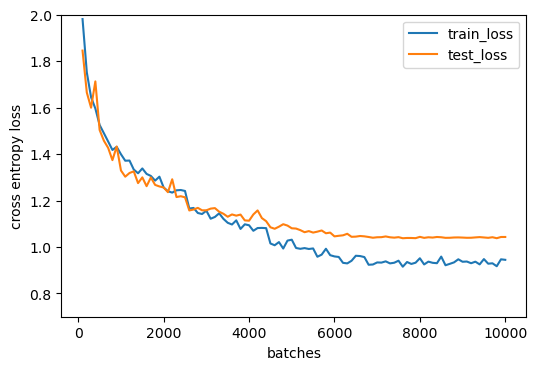

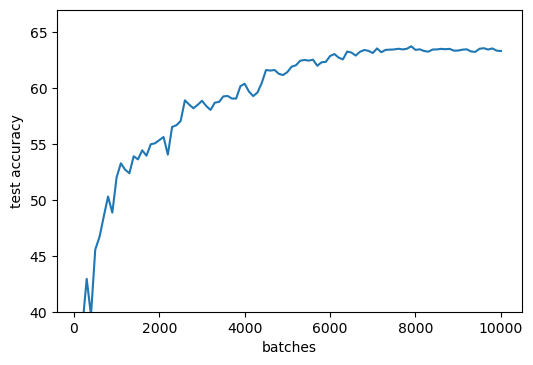

In [22]:
plot_loss(LeASLNN, y_lim=(0.7, 2))
plot_acc(LeASLNN, y_lim=(40, 67))

In [6]:
print("Training time (s):")
print(f"mean: {round(np.mean(LeASLNN.train_time), 3)}")
print(f"std: {round(np.std(LeASLNN.train_time), 3)}")

Training time (s):
mean: 1.024
std: 0.178


In [30]:
inference_times = inference_time(LeASLNN, input_shape=(1, 3, 32, 32), repetitions=10000, device="cuda")
print("Inference time GPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time GPU (ms):
1.196e+00
1.9e-01


In [31]:
inference_times = inference_time(LeASLNN, input_shape=(1, 3, 32, 32), repetitions=10000, device="cpu")
print("Inference time CPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time CPU (ms):
7.426e-01
2.4e-01


In [32]:
inference_times = inference_time(LeASLNN, input_shape=(100, 3, 32, 32), repetitions=10000, device="cuda")
print("Inference time GPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time GPU (ms):
2.706e+00
2.2e-01


In [40]:
inference_times = inference_time(LeASLNN, input_shape=(100, 3, 32, 32), repetitions=10000, device="cpu")
print("Inference time CPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time CPU (ms):
3.890e+00
7.0e-01


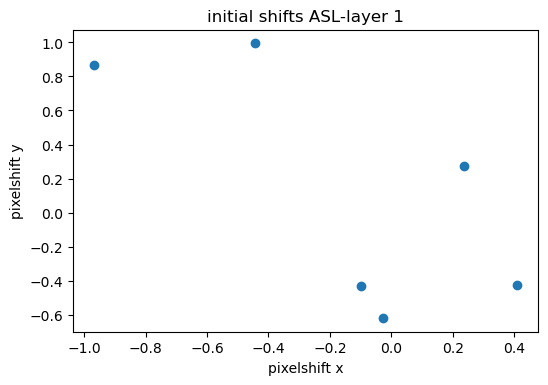

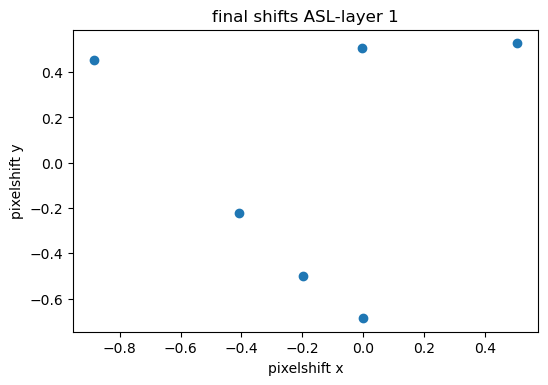

In [20]:
plot_shifts(LeASLNN)

## MNIST LeASLNet expansion-rate 3

In [4]:
# mock train_function of Optimizer to load the optimizer
ASL_train_function = None

with open('models/LeNet_Cifar/LeASLNet_optimizer.pkl', 'rb') as file:
    LeASLNet_optim = pickle.load(file)

best_parameters = LeASLNet_optim.get_best_parameters(3)
print(best_parameters)
parameters = best_parameters[2]

[{'acc': 70.484, 'lr': 0.026123046875, 'momentum': 0.928466796875, 'p_randomTransform': 0.00634765625}, {'acc': 69.916, 'lr': 0.09375, 'momentum': 0.65625, 'p_randomTransform': 0.3125}, {'acc': 67.734, 'lr': 0.08906396834655647, 'momentum': 0.5747879624008334, 'p_randomTransform': 0.6465142614354319}]


In [5]:
from Models import LeASLNet

LeASLNN_exp3 = LeASLNet(input_shape, num_labels, initial_lr=parameters["lr"], momentum=parameters["momentum"], weight_decay=0, device=device, expansion_rate=3)

summary(LeASLNN_exp3, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeASLNet                                 [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 32, 32]          456
│    └─BatchNorm2d: 2-2                  [100, 6, 32, 32]          12
│    └─Tanh: 2-3                         [100, 6, 32, 32]          --
│    └─AvgPool2d: 2-4                    [100, 6, 16, 16]          --
│    └─CSC_block: 2-5                    [100, 16, 16, 16]         --
│    │    └─Sequential: 3-1              --                        312
│    │    └─Conv2d: 3-2                  [100, 16, 16, 16]         112
│    └─Tanh: 2-6                         [100, 16, 16, 16]         --
│    └─AvgPool2d: 2-7                    [100, 16, 8, 8]           --
│    └─Flatten: 2-8                      [100, 1024]               --
│    └─Linear: 2-9                       [100, 120]                123,000
│    └─

In [6]:
PATH = "models/LeNet_Cifar/LeASLNet_exp3.pth"

if exists(PATH):
    LeASLNN_exp3 = torch.load(PATH)
    LeASLNN_exp3.eval()

In [7]:
criterion = CrossEntropyLoss()
epochs = 20

train_NN(LeASLNN_exp3, criterion, train_dataloader, test_dataloader, epochs=epochs, batches_to_test=100,
        patience=2,device=device, print_test=True, verbose=True, p_randomTransform=parameters["p_randomTransform"])

[1,   100] train_loss: 1.972
test_loss: 1.772, test_accuracy: 36.75
[1,   200] train_loss: 1.765
test_loss: 1.692, test_accuracy: 38.82
[1,   300] train_loss: 1.654
test_loss: 1.572, test_accuracy: 43.16
[1,   400] train_loss: 1.577
test_loss: 1.542, test_accuracy: 44.14
[1,   500] train_loss: 1.524
test_loss: 1.525, test_accuracy: 45.48
[2,   100] train_loss: 1.484
test_loss: 1.415, test_accuracy: 49.43
[2,   200] train_loss: 1.443
test_loss: 1.494, test_accuracy: 47.36
[2,   300] train_loss: 1.402
test_loss: 1.339, test_accuracy: 51.53
[2,   400] train_loss: 1.378
test_loss: 1.388, test_accuracy: 49.89
[2,   500] train_loss: 1.376
test_loss: 1.312, test_accuracy: 52.35
[3,   100] train_loss: 1.332
test_loss: 1.317, test_accuracy: 51.84
[3,   200] train_loss: 1.316
test_loss: 1.383, test_accuracy: 50.86
[3,   300] train_loss: 1.316
test_loss: 1.260, test_accuracy: 54.55
[3,   400] train_loss: 1.324
test_loss: 1.247, test_accuracy: 55.39
[3,   500] train_loss: 1.302
test_loss: 1.252, t

In [8]:
torch.save(LeASLNN_exp3, "./models/LeNet_Cifar/LeASLNet_exp3.pth")

In [23]:
LeASLNN_exp3 = torch.load("./models/LeNet_Cifar/LeASLNet_exp3.pth")

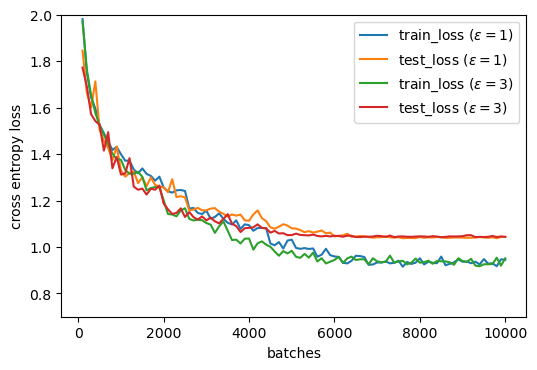

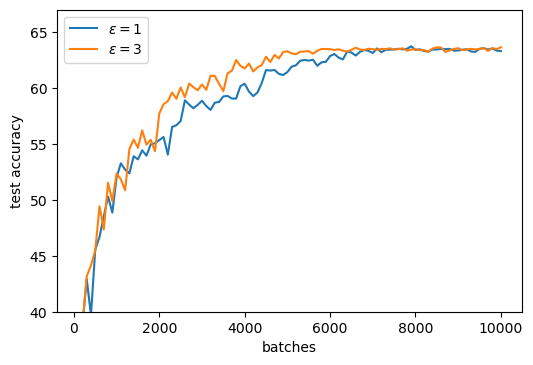

In [43]:
ASL_plot_loss(LeASLNN, LeASLNN_exp3, y_lim=(0.7, 2))
ASL_plot_acc(LeASLNN, LeASLNN_exp3, y_lim=(40, 67))

In [11]:
print("Training time (s):")
print(f"mean: {round(np.mean(LeASLNN_exp3.train_time), 3)}")
print(f"std: {round(np.std(LeASLNN_exp3.train_time), 3)}")

Training time (s):
mean: 1.178
std: 0.195


In [27]:
inference_times = inference_time(LeASLNN_exp3, input_shape=(1, 3, 32, 32), repetitions=10000, device="cuda")
print("Inference time GPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time GPU (ms):
1.260e+00
2.1e-01


In [28]:
inference_times = inference_time(LeASLNN_exp3, input_shape=(1, 3, 32, 32), repetitions=10000, device="cpu")
print("Inference time CPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time CPU (ms):
7.382e-01
3.0e-01


In [29]:
inference_times = inference_time(LeASLNN_exp3, input_shape=(100, 3, 32, 32), repetitions=10000, device="cuda")
print("Inference time GPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time GPU (ms):
3.051e+00
1.3e-01


In [30]:
inference_times = inference_time(LeASLNN_exp3, input_shape=(100, 3, 32, 32), repetitions=10000, device="cpu")
print("Inference time CPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time CPU (ms):
6.638e+00
1.3e+00


## CIFAR10 LeDepthNet

In [36]:
# mock train_function of Optimizer to load the optimizer
train_function = None

with open('models/LeNet_Cifar/LeDepthNet_optimizer.pkl', 'rb') as file:
    LeDepthNet_optim = pickle.load(file)

best_parameters = LeDepthNet_optim.get_best_parameters(3)
print(best_parameters)
parameters = best_parameters[2]

[{'acc': 76.096, 'lr': 0.03690704896414862, 'momentum': 0.7947779805241895, 'p_randomTransform': 0.00388878111128646}, {'acc': 69.042, 'lr': 0.09375, 'momentum': 0.65625, 'p_randomTransform': 0.3125}, {'acc': 68.756, 'lr': 0.08206054687499999, 'momentum': 0.6094042968750002, 'p_randomTransform': 0.70697265625}]


In [37]:
from Models import LeDepthNet

LeDepthNN = LeDepthNet(input_shape, num_labels, initial_lr=parameters["lr"], momentum=parameters["momentum"], weight_decay=0)

summary(LeDepthNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeDepthNet                               [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 32, 32]          456
│    └─BatchNorm2d: 2-2                  [100, 6, 32, 32]          12
│    └─Tanh: 2-3                         [100, 6, 32, 32]          --
│    └─AvgPool2d: 2-4                    [100, 6, 16, 16]          --
│    └─Depth_wise_block: 2-5             [100, 16, 16, 16]         --
│    │    └─Sequential: 3-1              --                        226
│    └─Tanh: 2-6                         [100, 16, 16, 16]         --
│    └─AvgPool2d: 2-7                    [100, 16, 8, 8]           --
│    └─Flatten: 2-8                      [100, 1024]               --
│    └─Linear: 2-9                       [100, 120]                123,000
│    └─Tanh: 2-10                        [100, 120]                --
│    └─L

In [35]:
PATH = "models/LeNet_Cifar/LeDepthNet.pth"

if exists(PATH):
    LeDepthNN = torch.load(PATH)
    LeDepthNN.eval()

In [38]:
criterion = CrossEntropyLoss()
epochs = 20

train_NN(LeDepthNN, criterion, train_dataloader, test_dataloader, epochs=epochs, batches_to_test=100,
        patience=2,device=device, print_test=True, verbose=True, p_randomTransform=parameters["p_randomTransform"])

[1,   100] train_loss: 2.024
test_loss: 1.814, test_accuracy: 35.7
[1,   200] train_loss: 1.755
test_loss: 1.635, test_accuracy: 41.06
[1,   300] train_loss: 1.626
test_loss: 1.580, test_accuracy: 42.77
[1,   400] train_loss: 1.552
test_loss: 1.490, test_accuracy: 46.02
[1,   500] train_loss: 1.496
test_loss: 1.455, test_accuracy: 48.34
[2,   100] train_loss: 1.465
test_loss: 1.399, test_accuracy: 49.33
[2,   200] train_loss: 1.426
test_loss: 1.407, test_accuracy: 49.56
[2,   300] train_loss: 1.406
test_loss: 1.341, test_accuracy: 51.78
[2,   400] train_loss: 1.413
test_loss: 1.327, test_accuracy: 52.34
[2,   500] train_loss: 1.359
test_loss: 1.359, test_accuracy: 51.34
[3,   100] train_loss: 1.353
test_loss: 1.298, test_accuracy: 53.47
[3,   200] train_loss: 1.342
test_loss: 1.313, test_accuracy: 52.7
[3,   300] train_loss: 1.317
test_loss: 1.315, test_accuracy: 53.07
[3,   400] train_loss: 1.320
test_loss: 1.283, test_accuracy: 54.14
[3,   500] train_loss: 1.314
test_loss: 1.323, tes

In [39]:
torch.save(LeDepthNN, "./models/LeNet_Cifar/LeDepthNet.pth")

In [40]:
LeDepthNN = torch.load("./models/LeNet_Cifar/LeDepthNet.pth")

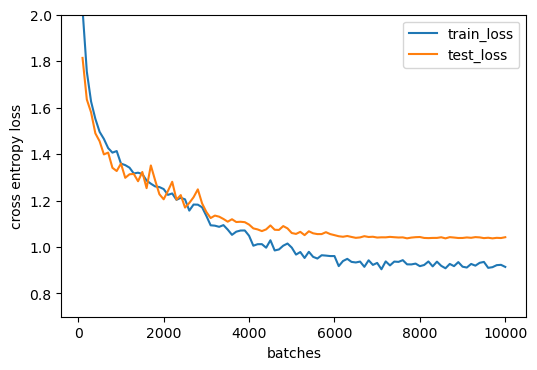

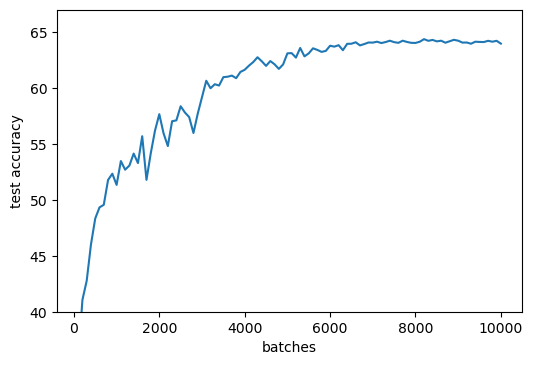

In [41]:
plot_loss(LeDepthNN, y_lim=(0.7, 2))
plot_acc(LeDepthNN, y_lim=(40, 67))

In [35]:
print("Training time (s):")
print(f"mean: {round(np.mean(LeDepthNN.train_time), 3)}")
print(f"std: {round(np.std(LeDepthNN.train_time), 3)}")

Training time (s):
mean: 0.82
std: 0.145


In [36]:
inference_times = inference_time(LeDepthNN, input_shape=(1, 3, 32, 32), repetitions=10000, device="cuda")
print("Inference time GPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time GPU (ms):
4.245e-01
4.6e-02


In [37]:
inference_times = inference_time(LeDepthNN, input_shape=(1, 3, 32, 32), repetitions=10000, device="cpu")
print("Inference time CPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time CPU (ms):
4.454e-01
2.2e-01


In [38]:
inference_times = inference_time(LeDepthNN, input_shape=(100, 3, 32, 32), repetitions=10000, device="cuda")
print("Inference time GPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time GPU (ms):
1.952e+00
4.9e-02


In [39]:
inference_times = inference_time(LeDepthNN, input_shape=(100, 3, 32, 32), repetitions=10000, device="cpu")
print("Inference time CPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time CPU (ms):
2.925e+00
6.8e-01
